In [1]:
from utils import query_author_id
from operator import itemgetter
from collections import Counter
# import sys
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install numpy
import numpy as np
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first_order, 

In [2]:
name_id_pairs = {
    "steve_blackburn": 2146610949,
    "kathryn_mckinley": 2115847858,
    "james_bornholt": 2026265091
}

def get_set_of_venues(name):
    res = query_author_id(name_id_pairs[name])
    references = [r["_source"]["References"] for r in res if "References" in r["_source"]]
    venues = []
    for ref in references:
        for v in ref:
            if "JournalId" in v:
                venues.append(v["JournalId"])
            if "ConferenceSeriesId" in v:
                venues.append(v["ConferenceSeriesId"])
    return venues

def get_set_of_venues_by_year(name):
    res = query_author_id(name_id_pairs[name])
    references = [(r["_source"]["Year"], r["_source"]["References"]) for r in res if "References" in r["_source"]]
    venues = {}
    for y, ref in references:
        if y not in venues:
            venues[y] = []
        for v in ref:
            if "JournalId" in v:
                venues[y].append(v["JournalId"])
            if "ConferenceSeriesId" in v:
                venues[y].append(v["ConferenceSeriesId"])
    return venues

def get_vector(bov, author_venue):
    c = Counter(author_venue)
    author_arr = [[float(c[b]) for b in bov]]
    return np.array(author_arr)

In [3]:
data = {}
for name in name_id_pairs.keys():
    data[name] = get_set_of_venues(name)

In [4]:
bag_of_venues = set()
sorted_list_bov = list()
for name, venues in data.items():
    print("{}: len(venues)={}, len(set(venues))={}".format(name, len(venues), len(set(venues))))
    [bag_of_venues.add(v) for v in venues]
print("Total # of venues = ", len(bag_of_venues))
sorted_list_bov = list(bag_of_venues)
number_of_venues = len(sorted_list_bov)

steve_blackburn: len(venues)=1375, len(set(venues))=156
kathryn_mckinley: len(venues)=1230, len(set(venues))=135
james_bornholt: len(venues)=37, len(set(venues))=20
('Total # of venues = ', 198)


In [5]:
vec = {}
for name, varray in data.items():
    vec[name] = get_vector(sorted_list_bov, varray)
# print(vec["steve_blackburn"])
# print(vec["kathryn_mckinley"])
# print(vec["james_bornholt"])

In [6]:
cosine_similarity(vec["steve_blackburn"], vec["kathryn_mckinley"])

array([[0.95721714]])

In [7]:
cosine_similarity(vec["steve_blackburn"], vec["james_bornholt"])

array([[0.35927077]])

In [8]:
cosine_similarity(vec["kathryn_mckinley"], vec["james_bornholt"])

array([[0.44655694]])

In [9]:
pca = PCA(n_components=2)
X = np.zeros((len(vec),number_of_venues))
for i, v in enumerate(vec.values()):
    X[i] = v
# print(X)

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

('original shape:   ', (3, 198))
('transformed shape:', (3, 2))


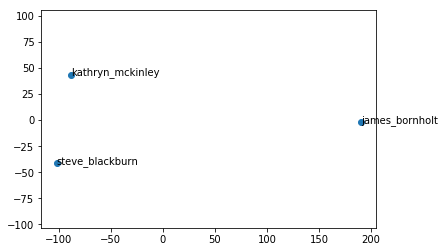

In [10]:
z = X_pca[:, 0]
y = X_pca[:, 1]
plt.scatter(z, y)
plt.axis('equal');
for i, name in enumerate(data.keys()):
    plt.annotate(name, (z[i],y[i]))

In [11]:
# generate vector by year
yeardata = {}
for name in name_id_pairs.keys():
    yeardata[name] = get_set_of_venues_by_year(name)

In [91]:
def author_year_plot(name):
    pca = PCA(n_components=2)
    pick = yeardata[name]
#     print((len(pick), number_of_venues))
    X = np.zeros((len(pick), number_of_venues))
    for i, v in enumerate(pick.values()):
        X[i] = get_vector(bag_of_venues, v)
#     print(X)

    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    
    if len(pick) > 1:
        z = X_pca[:, 0]
        y = X_pca[:, 1]
        plt.scatter(z, y)
        plt.axis('equal');
        for i, name in enumerate(pick.keys()):
            plt.annotate(name, (z[i],y[i]))
    else:
        plt.scatter([0],[0])
        plt.annotate(pick.keys()[0], (0,0))

('original shape:   ', (22, 198))
('transformed shape:', (22, 2))


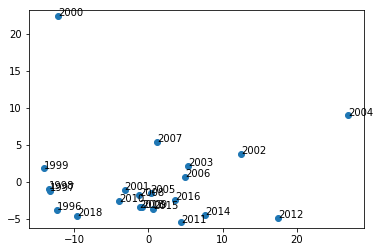

In [84]:
author_year_plot("steve_blackburn")

('original shape:   ', (19, 198))
('transformed shape:', (19, 2))


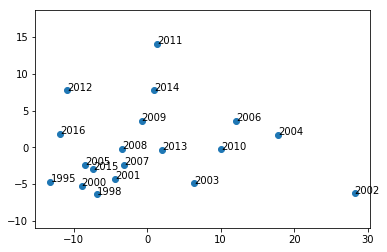

In [85]:
author_year_plot("kathryn_mckinley")

('original shape:   ', (1, 198))
('transformed shape:', (1, 1))


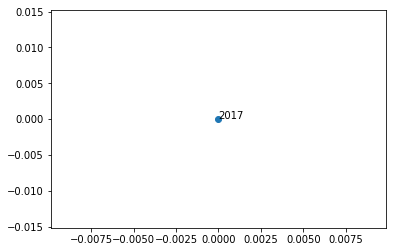

In [92]:
author_year_plot("james_bornholt")